In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Idanlau/Cloudera_Hackathon/Word-Encoding/artist_fame.csv")

In [3]:
df['price']

0      28.500 USD
1       3.000 USD
2       5.000 USD
3       5.000 USD
4       2.500 USD
          ...    
749       680 USD
750     1.275 USD
751       680 USD
752     1.275 USD
753       680 USD
Name: price, Length: 754, dtype: object

/var/folders/78/zn54_c9d2jb_8j8xx5s59dqw0000gn/T/ipykernel_15310/3442715267.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace(".","")


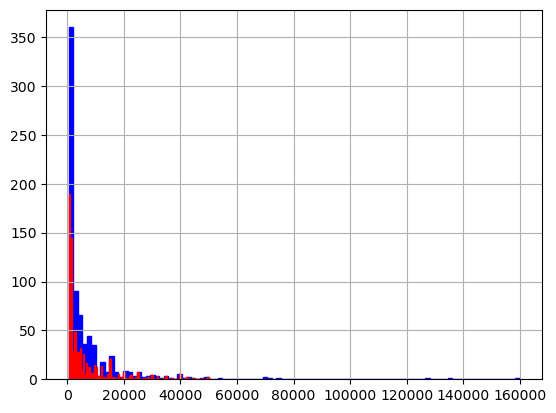

In [4]:
df['price'] = df['price'].str.replace("USD","") #Dropping the USD string so its just numbers
df['price'] = df['price'].str.replace(".","")
df['price'] = pd.to_numeric(df['price'])

df['price'].hist(bins=100, edgecolor='blue', color='blue')

threshold = df['price'].quantile(0.99)
df_filtered = df[df['price'] <= threshold]
df_filtered['price'].hist(bins=100, edgecolor='red', color='red')
df = df_filtered

In [5]:
movement_df = pd.get_dummies(df['movement'])
period_df = pd.get_dummies(df['period'])
movement_df.drop(columns='[nan]',inplace=True)
period_df.drop(columns='[nan]',inplace=True)
df.drop(columns='movement',inplace=True)
df.drop(columns='period',inplace=True)
df = df.join(movement_df)
df = df.join(period_df)
df['yearCreation'] = pd.to_numeric(df['yearCreation'],errors = "coerce")
nan_count = df['yearCreation'].isna().sum().sum()
#print(nan_count) #104/753 = around 13.8 percent of data missing for years!
df['yearCreation'] = df['yearCreation'].fillna(df['yearCreation'].median()) #Fill it with the median, any better approaches?

df['recency_log'] = np.log1p(2025 - df['yearCreation']) #2025 is the current year, we can use this to calculate how recent the art is
df.drop(columns='yearCreation',inplace=True) #Dropping the yearCreation column since we already have the recency_log

# df['yearCreation']


from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
condition = vectorizer.fit_transform(df['condition'])

from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer()
signed = vectorizer2.fit_transform(df['signed'])

condition_labels = pd.DataFrame(condition.toarray(),columns=vectorizer.get_feature_names_out())
signed_labels = pd.DataFrame(signed.toarray(),columns=vectorizer2.get_feature_names_out())

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
condition = vectorizer.fit_transform(df['condition'])

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer2 = TfidfVectorizer()
signed = vectorizer2.fit_transform(df['signed'])

condition_labels = pd.DataFrame(condition.toarray(),columns=vectorizer.get_feature_names_out())

df.drop(columns='signed',inplace=True)
df.drop(columns='condition',inplace=True)
df.drop(columns='artist',inplace=True)

signed_labels = signed_labels.astype(int)
condition_labels = condition_labels.astype(int)

df = df.join(condition_labels)
df = df.join(signed_labels,lsuffix="_left", rsuffix="_right", how='right')
df = df.drop(df.columns[[0, 1, 2,5]],axis = 1)

from sklearn.model_selection import train_test_split

X = df.loc[:, ~df.columns.isin(['artist', 'title', 'signed','condition','title_left','price'])]
Y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2)



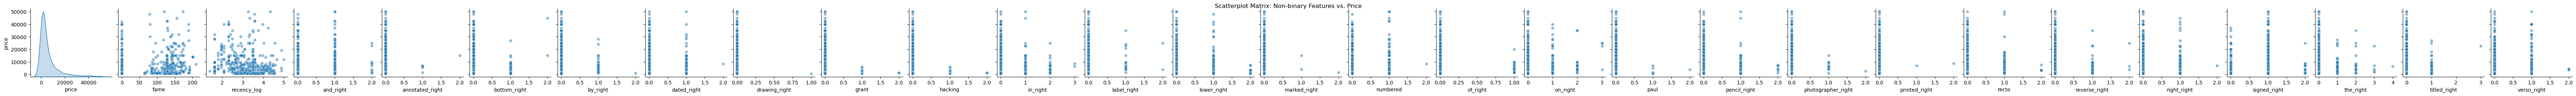

In [6]:
# Remove binary (OHE) columns: those with exactly 2 unique values (like 0/1)
non_binary_cols = [col for col in df.columns if df[col].nunique() > 2]
df_nonbinary = df[non_binary_cols]
# Ensure all columns are numeric (to plot scatter matrix)
numeric_cols = df_nonbinary.select_dtypes(include=['number']).columns.tolist()

# Include 'price' if not already in the list
if 'price' not in numeric_cols:
    numeric_cols.append('price')

df_plot = df[numeric_cols]
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_plot, y_vars=["price"], diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle("Scatterplot Matrix: Non-binary Features vs. Price", y=1.02)
plt.show()


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,\
RandomizedSearchCV

# def search_param():
#   param_grid = {
#       'n_estimators': [25, 50, 100, 150],
#       'max_features': ['sqrt', 'log2', None],
#       'max_depth': [10, 20, 30, 40],
#       'max_leaf_nodes': [2, 10, 20 , 25],
#   }


#   regr = GridSearchCV(RandomForestRegressor(),
#                             param_grid=param_grid)
#   regr.fit(X_train, y_train)
#   print(regr.best_estimator_)

# search_param()


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import statistics
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Drop rows where Y or any of X contains NaN or inf
mask = np.isfinite(Y) & np.all(np.isfinite(X), axis=1)
X = X[mask]
Y = Y[mask]
X = X.replace([np.inf, -np.inf], np.nan).dropna()
Y = Y.loc[X.index]  # make sure target matches
X = df.dropna().replace([np.inf, -np.inf], np.nan).dropna()
Y = X['price']
X = X.drop(columns=['price'])


regr = RandomForestRegressor(max_depth=20, random_state=0)
regr = XGBRegressor(n_estimators=100, max_depth=20, learning_rate=0.1, random_state=42)


MAE_errors = []
MAPE_errors = []
r2_scores = []
acc_10 = []
acc_20 = []
null_errors = []

for i in range(1, 11):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_test)

    importances = regr.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]

    feat_labels = df.columns[1:]

    # Null error (baseline model predicting y_test.mean())
    null_pred = np.full(y_test.shape, y_test.mean())
    null_error = mean_absolute_error(y_test, null_pred)
    null_errors.append(null_error)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Relative error-based accuracy
    rel_errors = np.abs((y_test - y_pred) / y_test)
    acc_10.append(np.mean(rel_errors < 0.10) * 100)
    acc_20.append(np.mean(rel_errors < 0.20) * 100)

    # Collect metrics
    MAE_errors.append(mae)
    MAPE_errors.append(mape)
    r2_scores.append(r2)

    # Print trial summary
    print(f"Trial {i}")
    print(f"Mean Actual Price (y_test.mean): {y_test.mean():.2f}")
    print(f"Training R²: {regr.score(X_train, y_train):.4f}")
    print(f"Testing R²: {r2:.4f}")
    print(f"MAE: ${mae:.2f}")
    print(f"MAPE: {mape * 100:.2f}%")
    print(f"Accuracy within ±10%: {acc_10[-1]:.2f}%")
    print(f"Accuracy within ±20%: {acc_20[-1]:.2f}%")

    for f in range(3):
        idx = sorted_indices[f]
        print(f"{f + 1}) {feat_labels[idx]:<15} Importance: {importances[idx]:.6f} | Index: {df.columns.get_loc(str(feat_labels[idx]))}")
    print("\n")

# Summary
print("==== Summary Over 10 Trials ====")
print(f"Average MAE: ${statistics.mean(MAE_errors):.2f}")
print(f"MAE Variance: {statistics.variance(MAE_errors):.2f}")
print(f"Average MAPE: {statistics.mean(MAPE_errors) * 100:.2f}%")
print(f"Average R² Score: {statistics.mean(r2_scores):.4f}")
print(f"Accuracy within ±10%: {statistics.mean(acc_10):.2f}%")
print(f"Accuracy within ±20%: {statistics.mean(acc_20):.2f}%\n")

print(f"Null Model MAE Mean: ${statistics.mean(null_errors):.2f}")
print(f"Null Model MAE Variance: {statistics.variance(null_errors):.2f}")


Trial 1
Mean Actual Price (y_test.mean): 5489.43
Training R²: 0.9865
Testing R²: 0.0904
MAE: $3729.49
MAPE: 159.98%
Accuracy within ±10%: 14.19%
Accuracy within ±20%: 27.03%
1) ry2008          Importance: 0.087931 | Index: 1174
2) 99              Importance: 0.076744 | Index: 841
3) chops           Importance: 0.046624 | Index: 914


Trial 2
Mean Actual Price (y_test.mean): 6405.00
Training R²: 0.9985
Testing R²: 0.2822
MAE: $3804.12
MAPE: 78.93%
Accuracy within ±10%: 25.00%
Accuracy within ±20%: 34.46%
1) 99              Importance: 0.113339 | Index: 841
2) Feminist Art    Importance: 0.066876 | Index: 12
3) ry2008          Importance: 0.066466 | Index: 1174


Trial 3
Mean Actual Price (y_test.mean): 5893.82
Training R²: 0.9994
Testing R²: 0.1890
MAE: $3785.71
MAPE: 97.93%
Accuracy within ±10%: 14.86%
Accuracy within ±20%: 28.38%
1) mount_right     Importance: 0.134849 | Index: 1107
2) 99              Importance: 0.113605 | Index: 841
3) 79              Importance: 0.084856 | Index: 8

### weighted ensemble

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import numpy as np
import statistics
import matplotlib.pyplot as plt

# Define models
rf_model = RandomForestRegressor(max_depth=20, random_state=0)
xgb_model = XGBRegressor(n_estimators=100, max_depth=20, learning_rate=0.1, random_state=42)
cat_model = CatBoostRegressor(verbose=0, depth=8, iterations=300, learning_rate=0.1, random_state=42)
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Evaluation trackers
MAE_errors = []
MAPE_errors = []
r2_scores = []
acc_10 = []
acc_20 = []
null_errors = []

# Individual model metrics
model_names = ['RandomForest', 'XGB', 'CatBoost', 'MLP']
model_maes = {name: [] for name in model_names}
model_mapes = {name: [] for name in model_names}
model_r2s = {name: [] for name in model_names}

for i in range(1, 11):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

    # Fit models
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    cat_model.fit(X_train, y_train)
    mlp_model.fit(X_train, y_train)

    # Predict
    y_rf = rf_model.predict(X_test)
    y_xgb = xgb_model.predict(X_test)
    y_cat = cat_model.predict(X_test)
    y_mlp = mlp_model.predict(X_test)

    # Compute individual R² scores
    r2_rf = r2_score(y_test, y_rf)
    r2_xgb = r2_score(y_test, y_xgb)
    r2_cat = r2_score(y_test, y_cat)
    r2_mlp = r2_score(y_test, y_mlp)

    # Normalize R² scores as weights (clip negative to 0 to avoid reverse contribution)
    r2_array = np.array([max(r2_rf, 0), max(r2_xgb, 0), max(r2_cat, 0), max(r2_mlp, 0)])
    weights = r2_array / np.sum(r2_array) if r2_array.sum() > 0 else np.ones_like(r2_array) / 4

    # Weighted ensemble prediction
    y_pred = weights[0]*y_rf + weights[1]*y_xgb + weights[2]*y_cat + weights[3]*y_mlp

    # Null model
    null_pred = np.full(y_test.shape, y_test.mean())
    null_error = mean_absolute_error(y_test, null_pred)
    null_errors.append(null_error)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rel_errors = np.abs((y_test - y_pred) / y_test)
    acc_10.append(np.mean(rel_errors < 0.10) * 100)
    acc_20.append(np.mean(rel_errors < 0.20) * 100)

    MAE_errors.append(mae)
    MAPE_errors.append(mape)
    r2_scores.append(r2)

    # Track individual model scores
    for name, pred, r2_val in zip(model_names, [y_rf, y_xgb, y_cat, y_mlp], r2_array):
        m_mae = mean_absolute_error(y_test, pred)
        m_mape = mean_absolute_percentage_error(y_test, pred)
        model_maes[name].append(m_mae)
        model_mapes[name].append(m_mape)
        model_r2s[name].append(r2_val)

    # Feature importances
    feat_labels = df.columns[1:]
    avg_importances = (rf_model.feature_importances_ +
                       xgb_model.feature_importances_ +
                       cat_model.feature_importances_) / 3
    sorted_indices = np.argsort(avg_importances)[::-1]

    print(f"\n📊 Trial {i}")
    print(f"Mean Actual Price: {y_test.mean():.2f}")
    for j, name in enumerate(model_names):
        print(f"{name} → R²: {r2_array[j]:.4f}, MAE: ${model_maes[name][-1]:.2f}, MAPE: {model_mapes[name][-1]*100:.2f}%")
    print(f"\nWeighted Ensemble → R²: {r2:.4f}, MAE: ${mae:.2f}, MAPE: {mape*100:.2f}%")
    print(f"Accuracy within ±10%: {acc_10[-1]:.2f}%, ±20%: {acc_20[-1]:.2f}%")

    for f in range(3):
        idx = sorted_indices[f]
        print(f"{f + 1}) {feat_labels[idx]:<15} Avg Importance: {avg_importances[idx]:.6f}")

# === Final Summary ===
print("\n==== Ensemble Summary Over 10 Trials ====")
print(f"Avg MAE: ${statistics.mean(MAE_errors):.2f}, Var: {statistics.variance(MAE_errors):.2f}")
print(f"Avg MAPE: {statistics.mean(MAPE_errors)*100:.2f}%")
print(f"Avg R²: {statistics.mean(r2_scores):.4f}")
print(f"±10% Accuracy: {statistics.mean(acc_10):.2f}%")
print(f"±20% Accuracy: {statistics.mean(acc_20):.2f}%")
print(f"Null MAE: ${statistics.mean(null_errors):.2f}, Var: {statistics.variance(null_errors):.2f}")

print("\n==== Individual Model Averages ====")
for name in model_names:
    print(f"{name} → Avg R²: {statistics.mean(model_r2s[name]):.4f}, "
          f"Avg MAE: ${statistics.mean(model_maes[name]):.2f}, "
          f"Avg MAPE: {statistics.mean(model_mapes[name])*100:.2f}%")


ModuleNotFoundError: No module named 'catboost'

In [29]:
print(X.shape[1])

1286


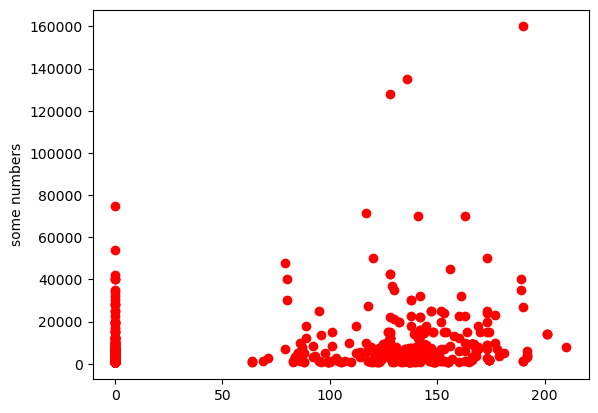

In [30]:
import matplotlib.pyplot as plt
plt.plot(X['fame'],Y, 'ro')
plt.ylabel('some numbers')
plt.show()

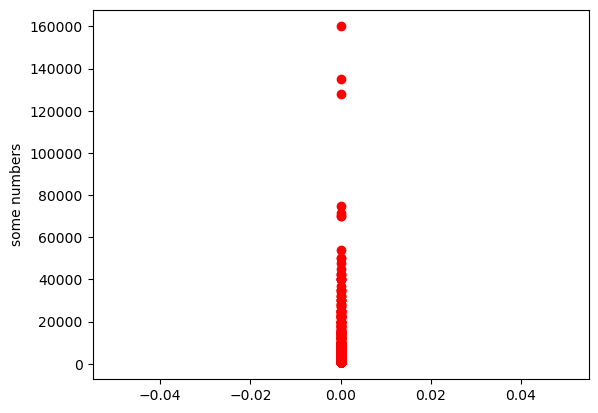

In [31]:
import matplotlib.pyplot as plt
plt.plot(X['occasional'],Y, 'ro')
plt.ylabel('some numbers')
plt.show()

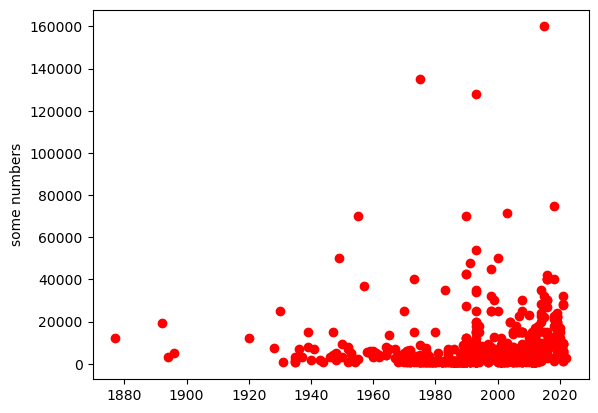

In [32]:
import matplotlib.pyplot as plt
plt.plot(X['yearCreation'],Y, 'ro')
plt.ylabel('some numbers')
plt.show()

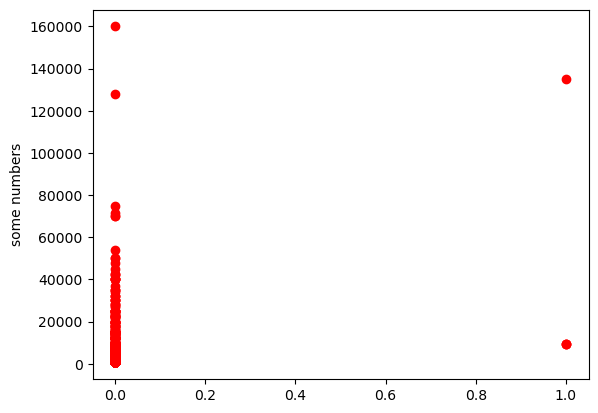

In [33]:
import matplotlib.pyplot as plt
plt.plot(X['Photorealism'],Y, 'ro')
plt.ylabel('some numbers')
plt.show()